In [1]:
#Because jedi completer is terrible!!!
%config Completer.use_jedi = False

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np


from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

from sklearn.metrics import mean_squared_error, r2_score
import sklearn.metrics as metrics

import statsmodels.api as sm

In [3]:
dataFrame = pd.read_csv('./data/forestfires.csv')

### Check for NULLs

In [4]:
dataFrame.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

### Summary of the data

In [5]:
dataFrame.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


### Rain Column

##### Rain column is COMPLETELY useless

In [6]:
print(len(dataFrame[dataFrame['rain'] > 0]))

dataFrame[dataFrame['rain'] > 0]

8


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
243,7,4,aug,sun,91.8,175.1,700.7,13.8,21.9,73,7.6,1.0,0.00
286,7,6,jul,wed,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.00
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82
500,8,6,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00
501,7,5,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00
502,4,4,aug,tue,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17


#### Drop 'rain' column

In [4]:
dataFrame.drop(labels=['rain'], axis = 1, inplace=True)

### Adding a burn flag column

##### Add a flag column

##### 0 Burn = 0
##### Non 0 burn = 1

In [5]:
areaValues = dataFrame[['area']].values

In [6]:
areaFlag = []

for each in areaValues:
    
    if each[0] == 0:
        
        areaFlag.append(0)
        
    else:
        
        areaFlag.append(1)

In [7]:
dataFrame['burn'] = areaFlag

### Adding a burn flag with 3 classes

##### Add another flag column

##### 0 burn = 0
##### burn less than 10 = 1
##### burn more than 10 = 2

In [8]:
burnLabel = []

for each in areaValues:
    
    if each[0] == 0:
        
        burnLabel.append(0)
        
    elif each[0] > 0 and each[0] < 10:
        
        burnLabel.append(1)
        
    else:
        
        burnLabel.append(2)

In [9]:
dataFrame['burnscale'] = burnLabel

### Burn Label distribution

In [81]:
len(dataFrame[dataFrame['burnlabel'] == 0])

KeyError: 'burnlabel'

In [82]:
len(dataFrame[dataFrame['burnlabel'] == 1])

KeyError: 'burnlabel'

In [84]:
len(dataFrame[dataFrame['burnlabel'] == 2])

247

### Exploring the distribution of area values

In [13]:
len(dataFrame)

517

#### There are a total of 517 records

#### Let us check the number of records with 0 and non 0 burnt areas

In [14]:
print('The number of records with zero burnt area is:  {}'
      .format(len(dataFrame[dataFrame['area'] == 0])))

print('The number of records with non zero burnt area is:  {}'
      .format(len(dataFrame[dataFrame['area'] != 0])))

The number of records with zero burnt area is:  247
The number of records with non zero burnt area is:  270


#### How about the number of records with burnt areas but not more than 1 hectare

In [15]:
print("The number of records with burnt area between 0 and 1 hectares is:  {}"
      .format(len(dataFrame.loc[(dataFrame['area'] > 0) & (dataFrame['area'] <= 1)])))

The number of records with burnt area between 0 and 1 hectares is:  27


#### The number of records with burnt areas greater than certain limits

In [24]:
limits = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

In [25]:
for each in limits:
    
    print('The number of records with burnt area more than {} hectares is:  {}'
          .format(each, len(dataFrame[dataFrame['area'] > each])))

The number of records with burnt area more than 0 hectares is:  270
The number of records with burnt area more than 1 hectares is:  243
The number of records with burnt area more than 10 hectares is:  95
The number of records with burnt area more than 20 hectares is:  59
The number of records with burnt area more than 30 hectares is:  43
The number of records with burnt area more than 40 hectares is:  31
The number of records with burnt area more than 50 hectares is:  24
The number of records with burnt area more than 60 hectares is:  20
The number of records with burnt area more than 70 hectares is:  18
The number of records with burnt area more than 80 hectares is:  15
The number of records with burnt area more than 90 hectares is:  12
The number of records with burnt area more than 100 hectares is:  11
The number of records with burnt area more than 200 hectares is:  5


#### Visualize this with a histogram using custom bin size

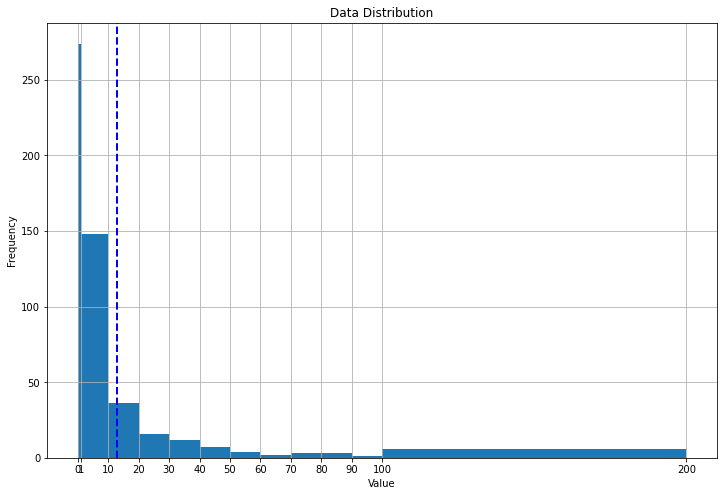

In [53]:
# Get the variable to examine
histData = dataFrame['area']

meanVal = histData.mean()

# Create a Figure
plt.figure(figsize=(12,8))

# Plot a histogram
plt.hist(histData, bins=limits)

plt.axvline(x=meanVal, color = 'blue', linestyle='dashed', linewidth = 2)

# Add titles and labels
plt.title('Data Distribution')
plt.xlabel('Value')
plt.xticks(ticks=limits)
plt.ylabel('Frequency')
plt.grid(True)

# Show the figure
plt.show()

### Distribution of predictor variables

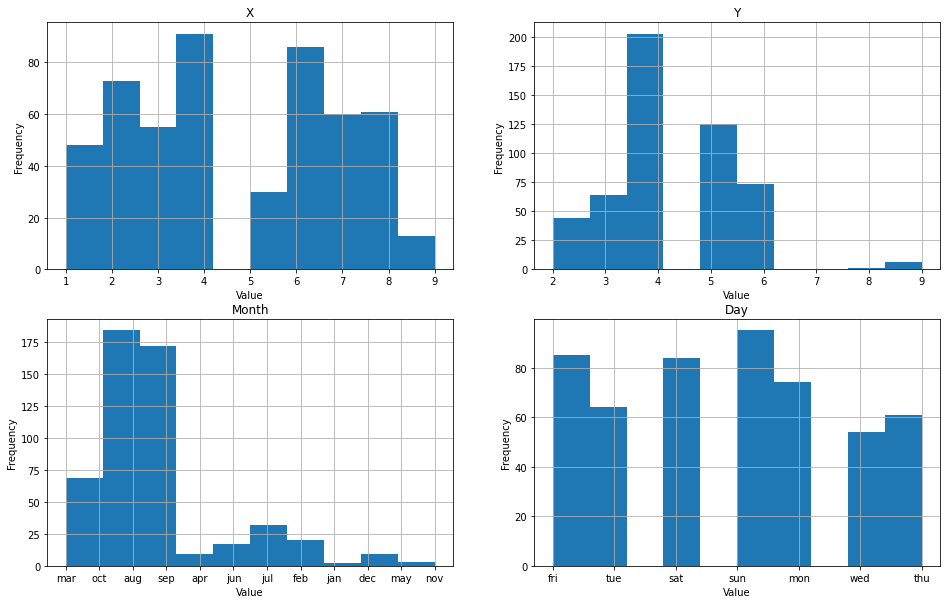

In [31]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(dataFrame['X'])
plt.grid(True)
plt.title('X')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(dataFrame['Y'])
plt.grid(True)
plt.title('Y')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(dataFrame['month'])
plt.grid(True)
plt.title('Month')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(dataFrame['day'])
plt.grid(True)
plt.title('Day')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.show()

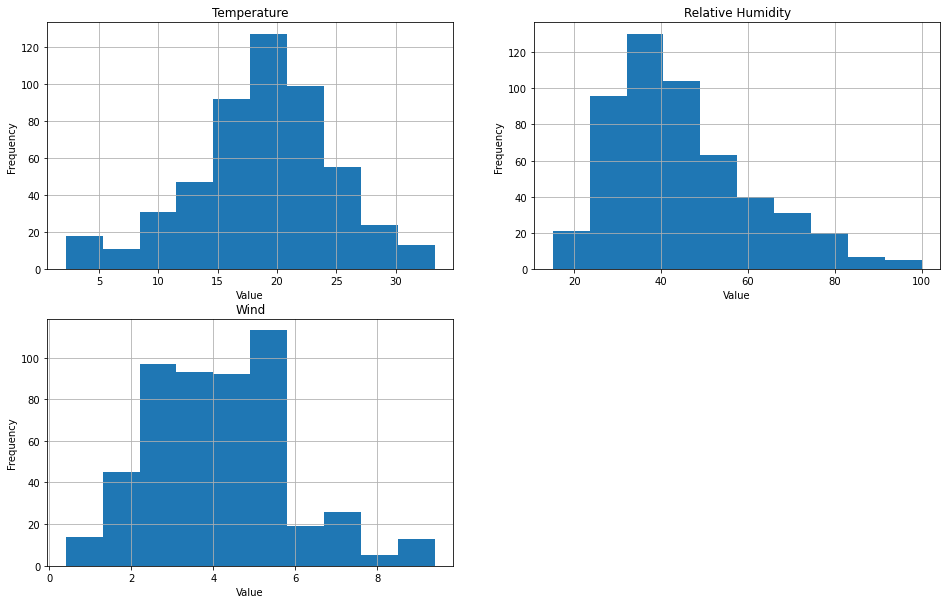

In [29]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(dataFrame['temp'])
plt.grid(True)
plt.title('Temperature')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(dataFrame['RH'])
plt.grid(True)
plt.title('Relative Humidity')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(dataFrame['wind'])
plt.grid(True)
plt.title('Wind')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

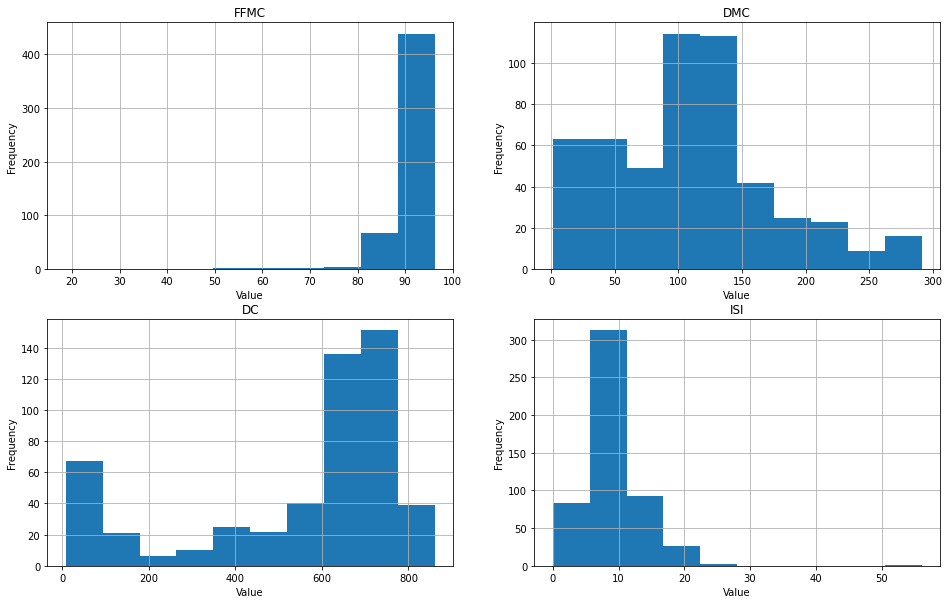

In [28]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(dataFrame['FFMC'])
plt.grid(True)
plt.title('FFMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(dataFrame['DMC'])
plt.grid(True)
plt.title('DMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(dataFrame['DC'])
plt.grid(True)
plt.title('DC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(dataFrame['ISI'])
plt.grid(True)
plt.title('ISI')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

### Correlation between the properties

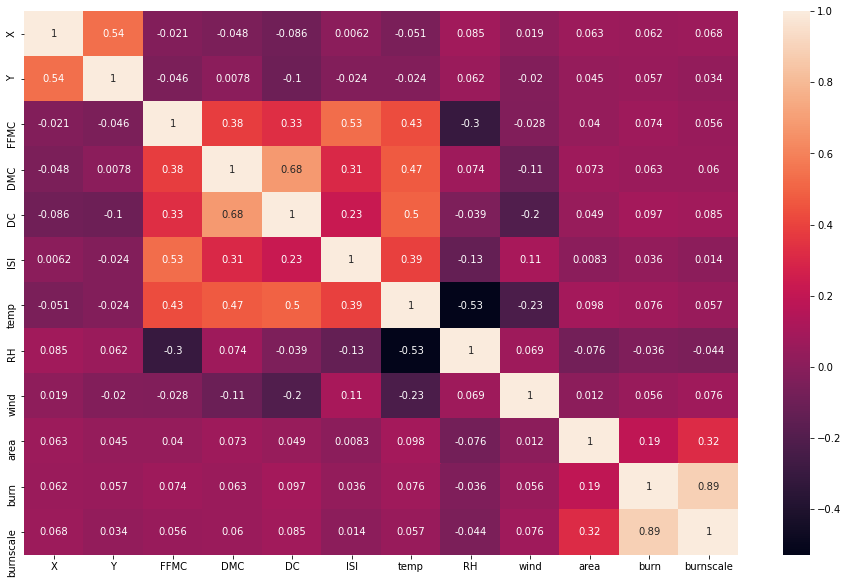

In [61]:
plt.figure(figsize=(16, 10))
corrMatrix = dataFrame.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

### Distribution of burnt area values

In [46]:
dataFrame[['area']].describe()

,area
count,517.000000
mean,12.847292
std,63.655818
min,0.000000
25%,0.000000
50%,0.520000
75%,6.570000
max,1090.840000


#### The mean value of burnt area is more than the 3rd quartile. Thats weird!!

### Let's look at the outliers

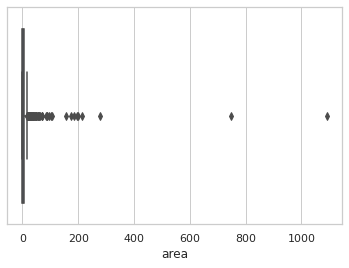

In [9]:
sb.set_theme(style="whitegrid")

ax = sb.boxplot(x=dataFrame["area"])

#### USELESS!!!


#### Calculate the outlier limit

In [38]:
thirdQuartile = dataFrame[['area']].describe().at['75%', 'area']

In [39]:
firstQuartile = dataFrame[['area']].describe().at['25%', 'area']

In [40]:
IQR = thirdQuartile - firstQuartile

In [41]:
outlierLimit = 1.5 * IQR

In [42]:
outlierLimit

9.855

#### Number of outliers

In [43]:
print(len(dataFrame[dataFrame['area'] > outlierLimit]))

97


### Make a dataset without outliers

In [44]:
cleanDF = dataFrame[dataFrame['area'] <= outlierLimit]

In [45]:
cleanDF.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,area,burn,burnscale
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,4.611905,4.302381,90.620714,109.586190,543.507857,9.078333,18.884762,44.509524,3.948095,1.515357,0.411905,0.411905
std,2.312021,1.253727,5.767668,62.958875,249.958323,4.634413,5.638184,16.240655,1.763383,2.486176,0.492765,0.492765
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,69.425000,436.600000,6.500000,15.575000,33.000000,2.700000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.650000,106.900000,658.200000,8.400000,19.200000,42.000000,4.000000,0.000000,0.000000,0.000000
75%,6.250000,5.000000,92.800000,142.400000,713.900000,10.700000,22.800000,53.000000,4.900000,2.140000,1.000000,1.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,32.600000,100.000000,9.400000,9.770000,1.000000,1.000000


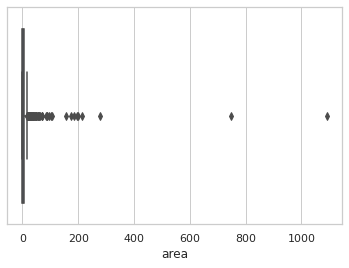

In [9]:
sb.set_theme(style="whitegrid")

ax = sb.boxplot(x=cleanDF["area"])

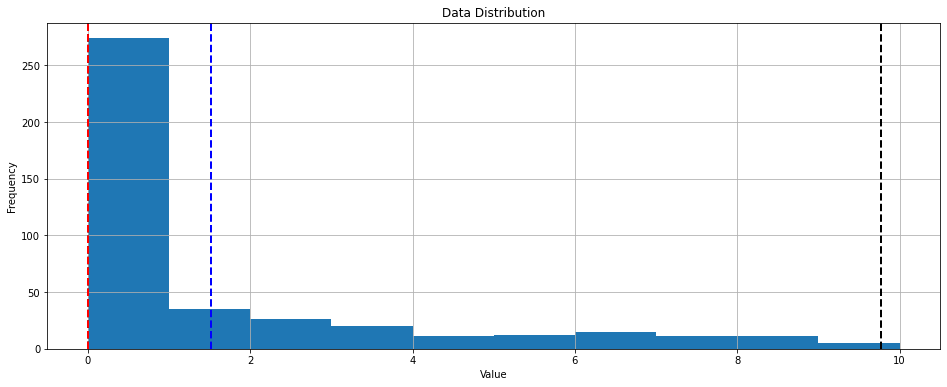

In [57]:
histData = cleanDF['area']


plt.figure(figsize=(16, 6))

minVal = histData.min()
meanVal = histData.mean()
medVal = histData.median()
maxVal = histData.max()


plt.hist(histData, bins=[0,1,2,3,4,5,6,7,8,9,10])

plt.axvline(x=meanVal, color = 'blue', linestyle='dashed', linewidth = 2)
plt.axvline(x=maxVal, color = 'black', linestyle='dashed', linewidth = 2)
plt.axvline(x=minVal, color = 'black', linestyle='dashed', linewidth = 2)
plt.axvline(x=medVal, color = 'red', linestyle='dashed', linewidth = 2)

plt.grid(True)
plt.title('Data Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

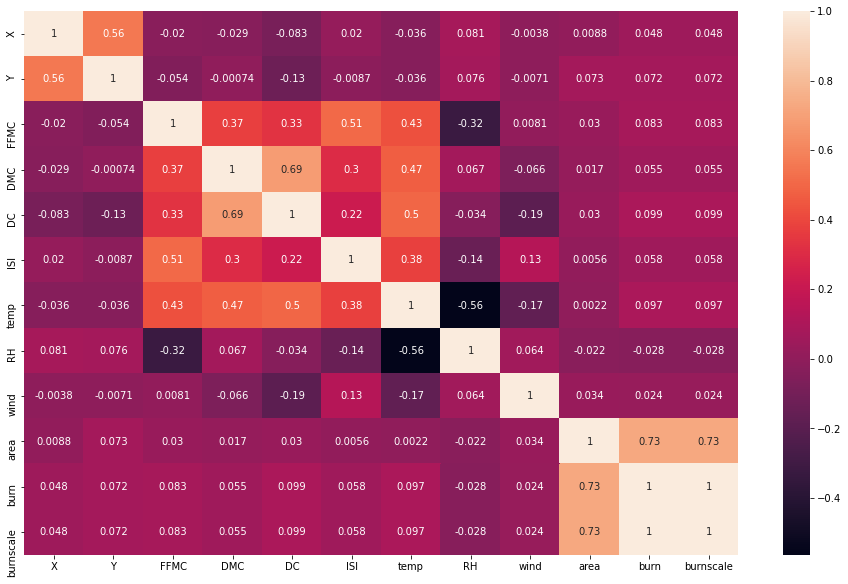

In [63]:
plt.figure(figsize=(16, 10))
corrMatrix = cleanDF.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

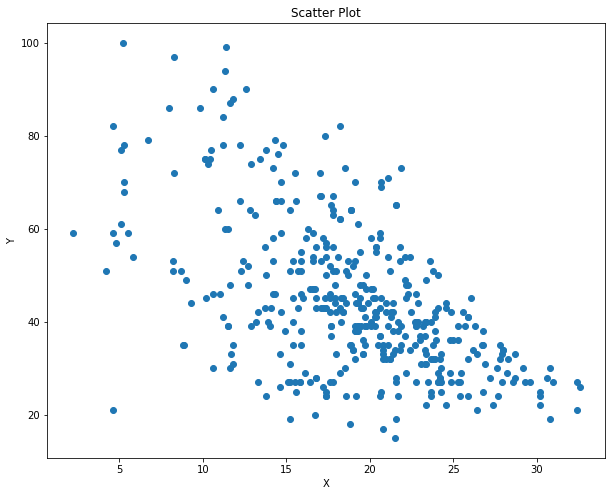

In [68]:
plt.figure(figsize=(10,8))
plt.scatter(x=cleanDF['temp'] , y=cleanDF['RH'])
plt.title('Scatter Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [34]:
list(dataFrame.columns)

['X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'area',
 'burn',
 'burnscale']

In [43]:
dataFrame.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,area,burn,burnscale
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0,0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0,0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0,0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.0,0,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0,0


In [44]:
X, Y = dataFrame[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']].values, dataFrame['area'].values

In [ ]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.10)

In [50]:
print ('Training Set: {} rows\n\nTest Set: {} rows'.format(XTrain.shape[0], XTest.shape[0]))

Training Set: 465 rows

Test Set: 52 rows


In [78]:
results = sm.OLS(Y,X).fit()

results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.060
Model:                            OLS   Adj. R-squared (uncentered):              0.043
Method:                 Least Squares   F-statistic:                              3.588
Date:                Fri, 26 Mar 2021   Prob (F-statistic):                    0.000241
Time:                        15:52:10   Log-Likelihood:                         -2874.9
No. Observations:                 517   AIC:                                      5768.
Df Residuals:                     508   BIC:                                      5806.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8877      1.443      1.308      0.191      -0.947       4.722
x2             0.5444      2.691      0.202      0.840      -4.743       5.832
x3            -0.0894      0.244     -0.367      0.714      -0.568       0.389
x4             0.0790      0.064      1.237      0.217      -0.046       0.204
x5            -0.0031      0.016     -0.189      0.850      -0.035       0.029
x6            -0.6902      0.702     -0.983      0.326      -2.070       0.690
x7             0.7483      0.748      1.000      0.318      -0.721       2.218
x8            -0.2516      0.204     -1.233      0.218      -0.653       0.149
x9             1.4890      1.632      0.913      0.362      -1.717       4.695
==============================================================================
Omnibus:                      975.157   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           781572.674
Skew:                          12.573   Prob(JB):                         0.00
Kurtosis:                     191.811   Cond. No.                         629.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
model = LinearRegression().fit(XTrain, YTrain)

In [60]:
predictions = model.predict(XTest)

In [54]:
YTest

array([1.0930e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 2.6130e+01, 1.1190e+01, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 4.4100e+00, 1.6000e+01, 0.0000e+00, 1.0130e+01,
       0.0000e+00, 1.0730e+01, 0.0000e+00, 1.2600e+00, 0.0000e+00,
       1.8300e+01, 7.3100e+00, 0.0000e+00, 4.4200e+00, 2.1000e-01,
       0.0000e+00, 9.4100e+00, 3.7100e+00, 1.4600e+00, 1.0010e+01,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8660e+01, 0.0000e+00,
       0.0000e+00, 7.4628e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.9400e+00, 9.0000e-02, 7.2000e-01, 7.4000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.2070e+01, 0.0000e+00, 0.0000e+00,
       1.1060e+01, 5.8300e+00])

In [62]:
predictDF = pd.DataFrame(columns=['Predictions', 'Actual'], data=zip(predictions, YTest))

In [63]:
predictDF

,Predictions,Actual
0,5.481738,10.93
1,20.186222,0.00
2,13.127850,0.00
3,9.746786,0.00
4,19.109491,0.00
5,16.264283,0.00
6,10.857389,26.13
7,8.009431,11.19
8,12.607661,0.00
9,9.645352,0.00


In [79]:
def regressionResults(YTrue, predictions):

    # Regression metrics
    explainedVariance=metrics.explained_variance_score(YTrue, predictions)
    MAE=metrics.mean_absolute_error(YTrue, predictions) 
    MSE=metrics.mean_squared_error(YTrue, predictions) 
    r2=metrics.r2_score(YTrue, predictions)

    print('\nexplained_variance: ', round(explainedVariance,4))    
    print('\nr2: ', round(r2,4))
    print('\nMAE: ', round(MAE,4))
    print('\nMSE: ', round(MSE,4))
    print('\nRMSE: ', round(np.sqrt(MSE),4))

In [80]:
regressionResults(YTest, predictions)


explained_variance:  0.029

r2:  0.0249

MAE:  24.9723

MSE:  10174.7085

RMSE:  100.8698


### Lasso

In [85]:
# Fit a lasso model on the training set
model = Lasso().fit(XTrain, YTrain)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(XTest)

regressionResults(YTest, predictions)

Lasso() 


explained_variance:  0.0275

r2:  0.0232

MAE:  24.7199

MSE:  10192.4887

RMSE:  100.9579


### Decision Tree

In [105]:
model = DecisionTreeRegressor().fit(XTrain, YTrain)
print (model, "\n")

DecisionTreeRegressor() 



In [106]:
predictions = model.predict(XTest)

regressionResults(YTest, predictions)


explained_variance:  -0.1445

r2:  -0.1453

MAE:  30.3378

MSE:  11950.2629

RMSE:  109.3173


### Random Forest

In [114]:
model = RandomForestRegressor().fit(XTrain, YTrain)
print (model, "\n")

RandomForestRegressor() 



In [115]:
predictions = model.predict(XTest)

regressionResults(YTest, predictions)


explained_variance:  -0.073

r2:  -0.0732

MAE:  32.7123

MSE:  11197.5738

RMSE:  105.8186


### Gradient Boosting

In [117]:
model = GradientBoostingRegressor().fit(XTrain, YTrain)

In [118]:
predictions = model.predict(XTest)

c


explained_variance:  0.013

r2:  0.008

MAE:  25.7964

MSE:  10351.0174

RMSE:  101.7399


### Hyperparameters Gridsearch

In [129]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(XTrain, YTrain)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(XTest)

regressionResults(YTest, predictions)

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 50} 

GradientBoostingRegressor(n_estimators=50) 


explained_variance:  -0.0039

r2:  -0.0108

MAE:  24.5343

MSE:  10547.1216

RMSE:  102.6992


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Get a scaler object
scaler = MinMaxScaler()

# Create a new dataframe for the scaled values
df_normalized = df_sample[['Name', 'Grade', 'StudyHours']].copy()

# Normalize the numeric columns
df_normalized[['Grade','StudyHours']] = scaler.fit_transform(df_normalized[['Grade','StudyHours']])

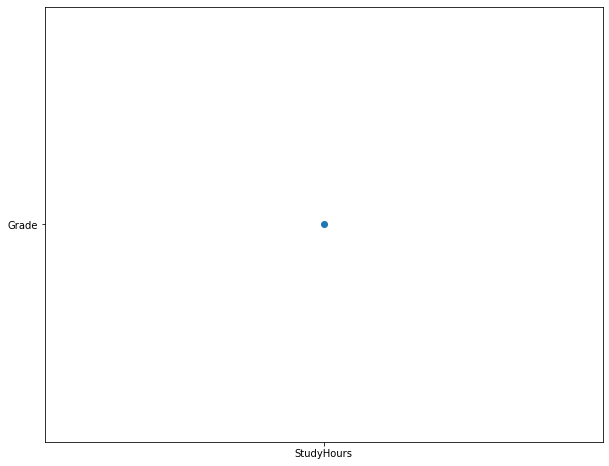

In [59]:
plt.figure(figsize=(10,8))
plt.scatter(x='StudyHours', y='Grade')
plt.show()

In [ ]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()
# X, y = df[['NumberofEmployees','ValueofContract']], df.AverageNumberofTickets
# model.fit(X, y)
# model.score(X, y)